# Searching for a Needle in a "Signal Haystack"

In [1]:
import numpy as np
import math, random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, savefig
%matplotlib inline
font = {'family': 'arial','color':  'darkred','weight': 'normal','size': 18}
plt.rcParams['figure.figsize'] = [12, 8.0]
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({"axes.grid" : True, "grid.color": "grey"})
plt.rcParams['grid.linestyle'] = ':'

from platform import python_version
print("Running Python:",python_version())

from IPython.display import display, Markdown
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

Running Python: 3.9.9


## Discussion:
* Consider case of a received signal that is weak (low amplitude) and there is lots of noise.

* All we know is that it is a sinusoidal signal and we have rough idea of the signal frequency

In [2]:
dt = 0.001 # emaulate measuring a cts signal by having dt very small compared to freq of signal
tf = 20 # 2 o sec of data
t = np.arange(0,tf,dt)

In [3]:
# Truth (i.e. not known to us)
omega0 = 11 # rads/sec
f0 = omega0/(2*np.pi) # Hz
T0 = 1/f0  # period in secs

In [4]:
# Measured
omega =  2*np.pi # a (bad) guess
phi_true = np.random.rand(1)*2*np.pi  # varied phase offset
y_true = np.sin(omega0 * t + phi_true) 
y = y_true + 20*np.random.randn(np.size(t))  # add some noise
# Faked as if I knew omega but not phi
y_faked = np.sin(omega0 * t) 

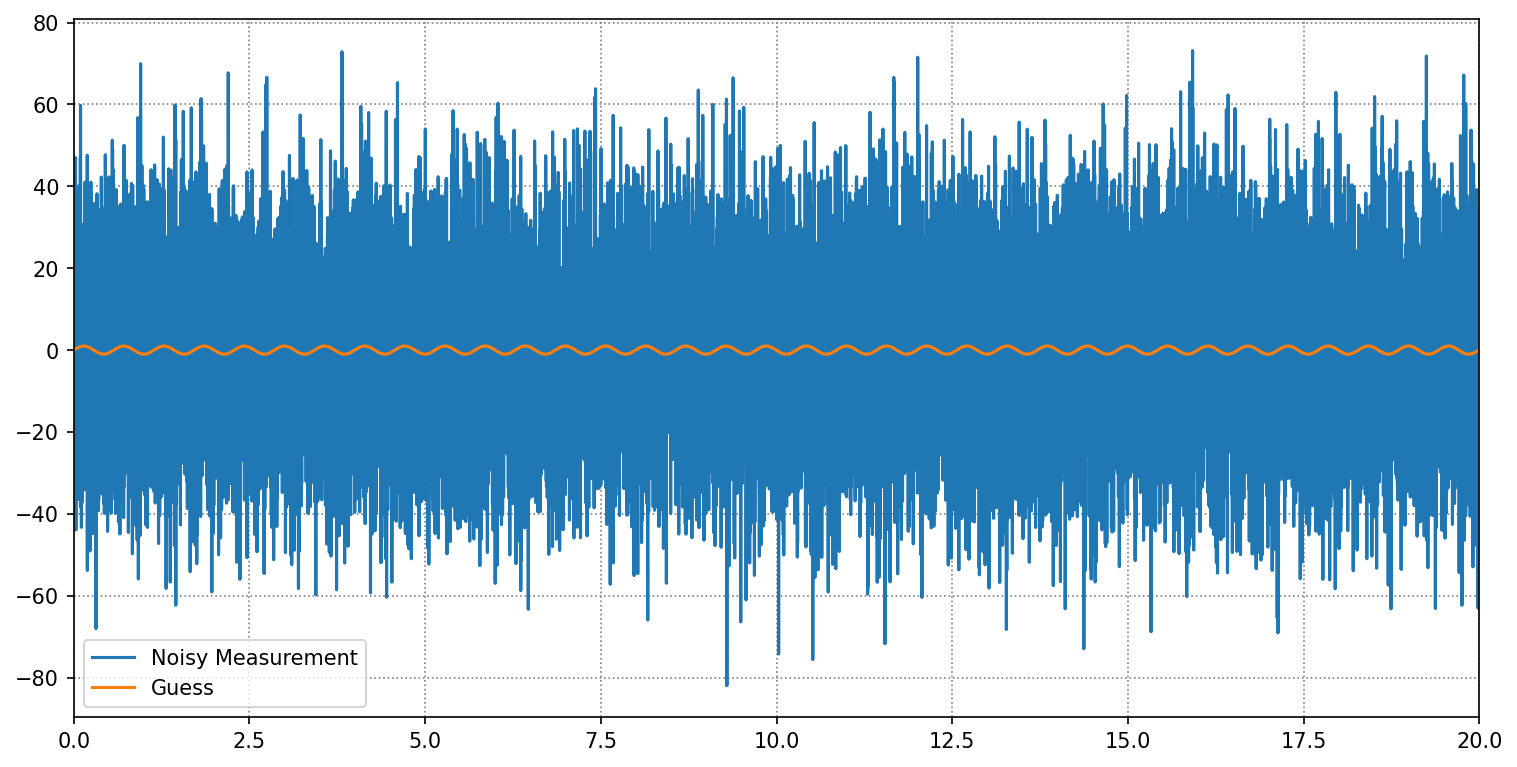

In [5]:
fig = figure(figsize=(10, 5),dpi=150,constrained_layout = True)
plt.plot(t,y,label='Noisy Measurement')
plt.plot(t,y_faked,label='Guess')
plt.legend()
plt.xlim(0,tf)
plt.grid(True)
plt.show()

## Pattern Matching
* Even if we knew the freqeuncy of the signal (orange line) - we don't the $\phi$ - the phase offset
* That offset depends on clock offsets in systems that are hard to keep synchronized in distributed systems (think satellites)

* Thus we have to do pattern matching - we basically create a replica signal as 
above, and then choose a range of $0\leq\phi\leq 2\pi$ to see if any match better than others

* Matching deptermined by computing the *correlation*
$$ C[j] =\sum_i y_{meas}[i] y_{replica}[i,j]$$
where $i$ is the index over mesurements taken and $j$ determines what value of $\phi$ is being used

* Must pay attention to the end points of the replica signal (use np.roll).

* We don't know the right amplitude to use either, but that is a scaling error in all $C[j]$ values - so can just look for the largest value across all computed.

In [ ]:
#Must determine how data points we are going to sweep over phi - nominally depends on frequency guess
N0 = 2*int(T0/dt) # number of samples per period 

# Implement the correlation process between 2 signals - sweep overal all possible offsets in 1 loop
def my_correlate(A,B,N = N0):
    C = np.zeros([N,1]) # confirm which N is being used
    for ii in np.arange(0,N):
        C[ii] = np.correlate(A, np.roll(B,ii))
    return C

In [25]:
def func(phi_test = 0):
    fig = figure(figsize=(10, 5),dpi=150,constrained_layout = True)
    y_test = 0.2*np.sin(omega0 * t + phi_test)  # another measured one (diff amplitude)
    plt.plot(t,y_true,label='Truth') # true signal from above (no noise)
    plt.plot(t,y_test,'r--',label='Guess')
    plt.xlim(0,3)
    plt.xlabel('Time [s]')
    plt.legend()
    plt.grid(True)
    plt.title(f'Correlation for $\phi = $ {phi_test:.2f} is {np.correlate(y_true,y_test)[0]:.2f}')
    plt.text(0.25,-1,f'Actual $\phi = $ {phi_true[0]:.2f}') #   
    plt.show()

yout = interactive(func,phi_test=(-2*np.pi,2*np.pi,0.1))
yout


interactive(children=(FloatSlider(value=0.0, description='phi_test', max=6.283185307179586, min=-6.28318530717…

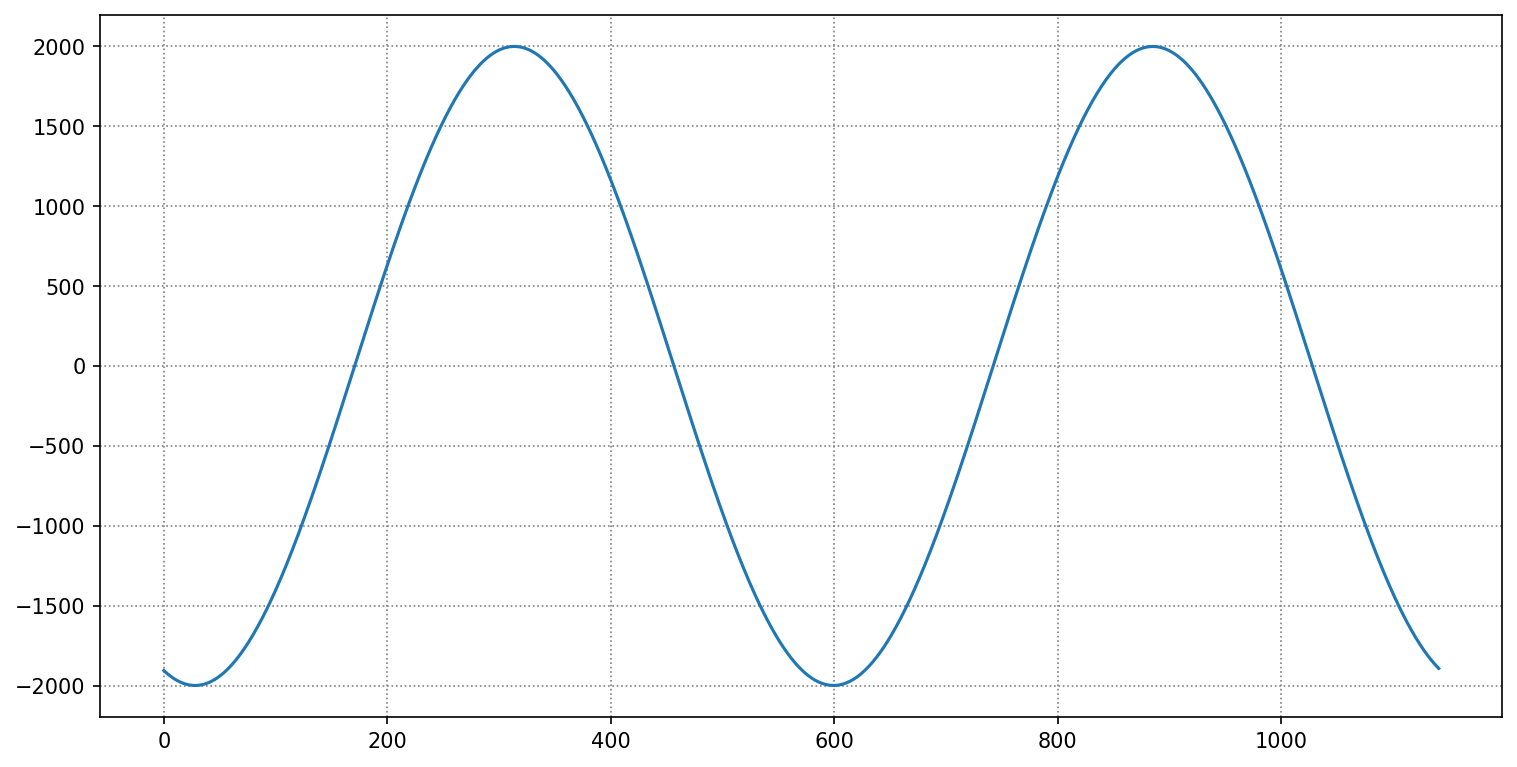

In [24]:
fig = figure(figsize=(10, 5),dpi=150,constrained_layout = True)
plt.plot(my_correlate(y_true,0.2*np.sin(omega0 * t)))    
plt.grid(True)

plt.show()

## Now back to analyzing the meaured data

In [21]:
z = my_correlate(y_faked,y_true)

# Look for largest value of the 
phi_corr = 2 * (2 * np.pi) * (np.argmax(z)/N0) # 4pi bec N0 is for 2 periods
PHI = np.arange(0,N0)*4*np.pi/N0 # 4pi bec N0 is for 2 periods

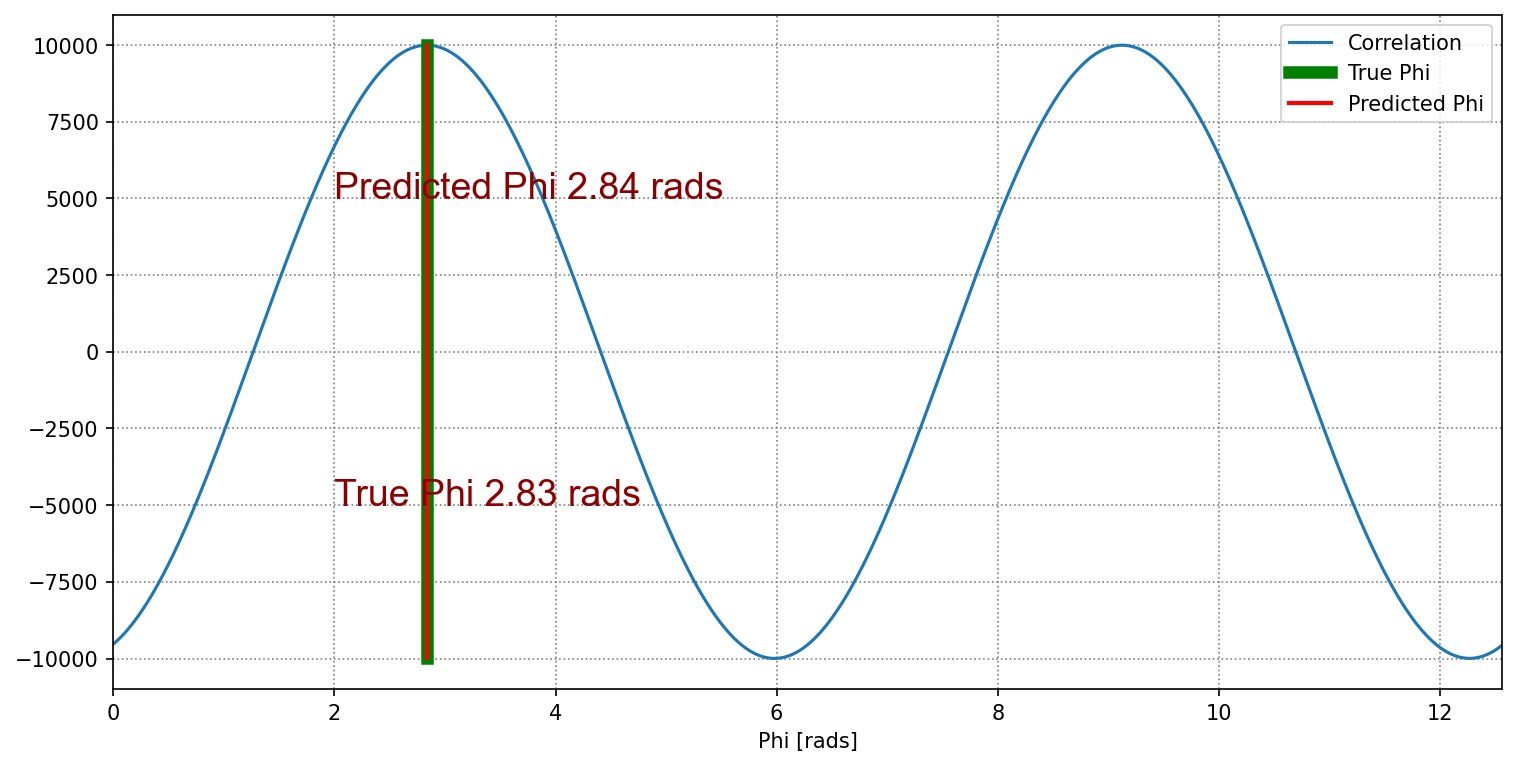

Predicted Phi is 2.84 rads
True Phi is 2.83 rads


In [26]:
fig = figure(figsize=(10, 5),dpi=150,constrained_layout = True)
plt.plot(PHI,z,label='Correlation')
plt.plot([phi_true,phi_true],[max(z),-max(z)],'g-',lw=6,label='True Phi')
plt.plot([phi_corr,phi_corr],[max(z),-max(z)],'r-',lw=2,label='Predicted Phi')
plt.text(2, max(z)/2, f'Predicted Phi {phi_corr:.2f} rads', fontdict=font)
plt.text(2, -max(z)/2, f'True Phi {phi_true[0]:.2f} rads', fontdict=font)
plt.grid(True)
plt.xlabel('Phi [rads]')
plt.xlim(0,4*np.pi)
plt.legend()
plt.show()

print(f'Predicted Phi is {phi_corr:.2f} rads')
print(f'True Phi is {phi_true[0]:.2f} rads')

## Now on to the hard case - what if we don't know $\omega$ very well
* THoughts on why that might happen?

In [10]:
# Set up a range of possible Omega values 
# Recall truth is Omega0, but we think it is Omega_guess
omega_guess = 5
# Create a range of Nw values of possible Omegas about the true Omega0
Nw = 50
Wrange = abs(omega_guess - omega0) + 1
d_omega = Wrange/Nw;
dd = np.arange(-Nw,Nw,1);
omega_range = omega0 + dd*d_omega

CC = np.zeros([np.size(dd),N0])
for ii in dd:
    y_test = np.sin((omega0 + d_omega*ii) * t) # new test freq
    CC[Nw + ii,:] = my_correlate(y_test,y).T # this sweep over all phase offsets 

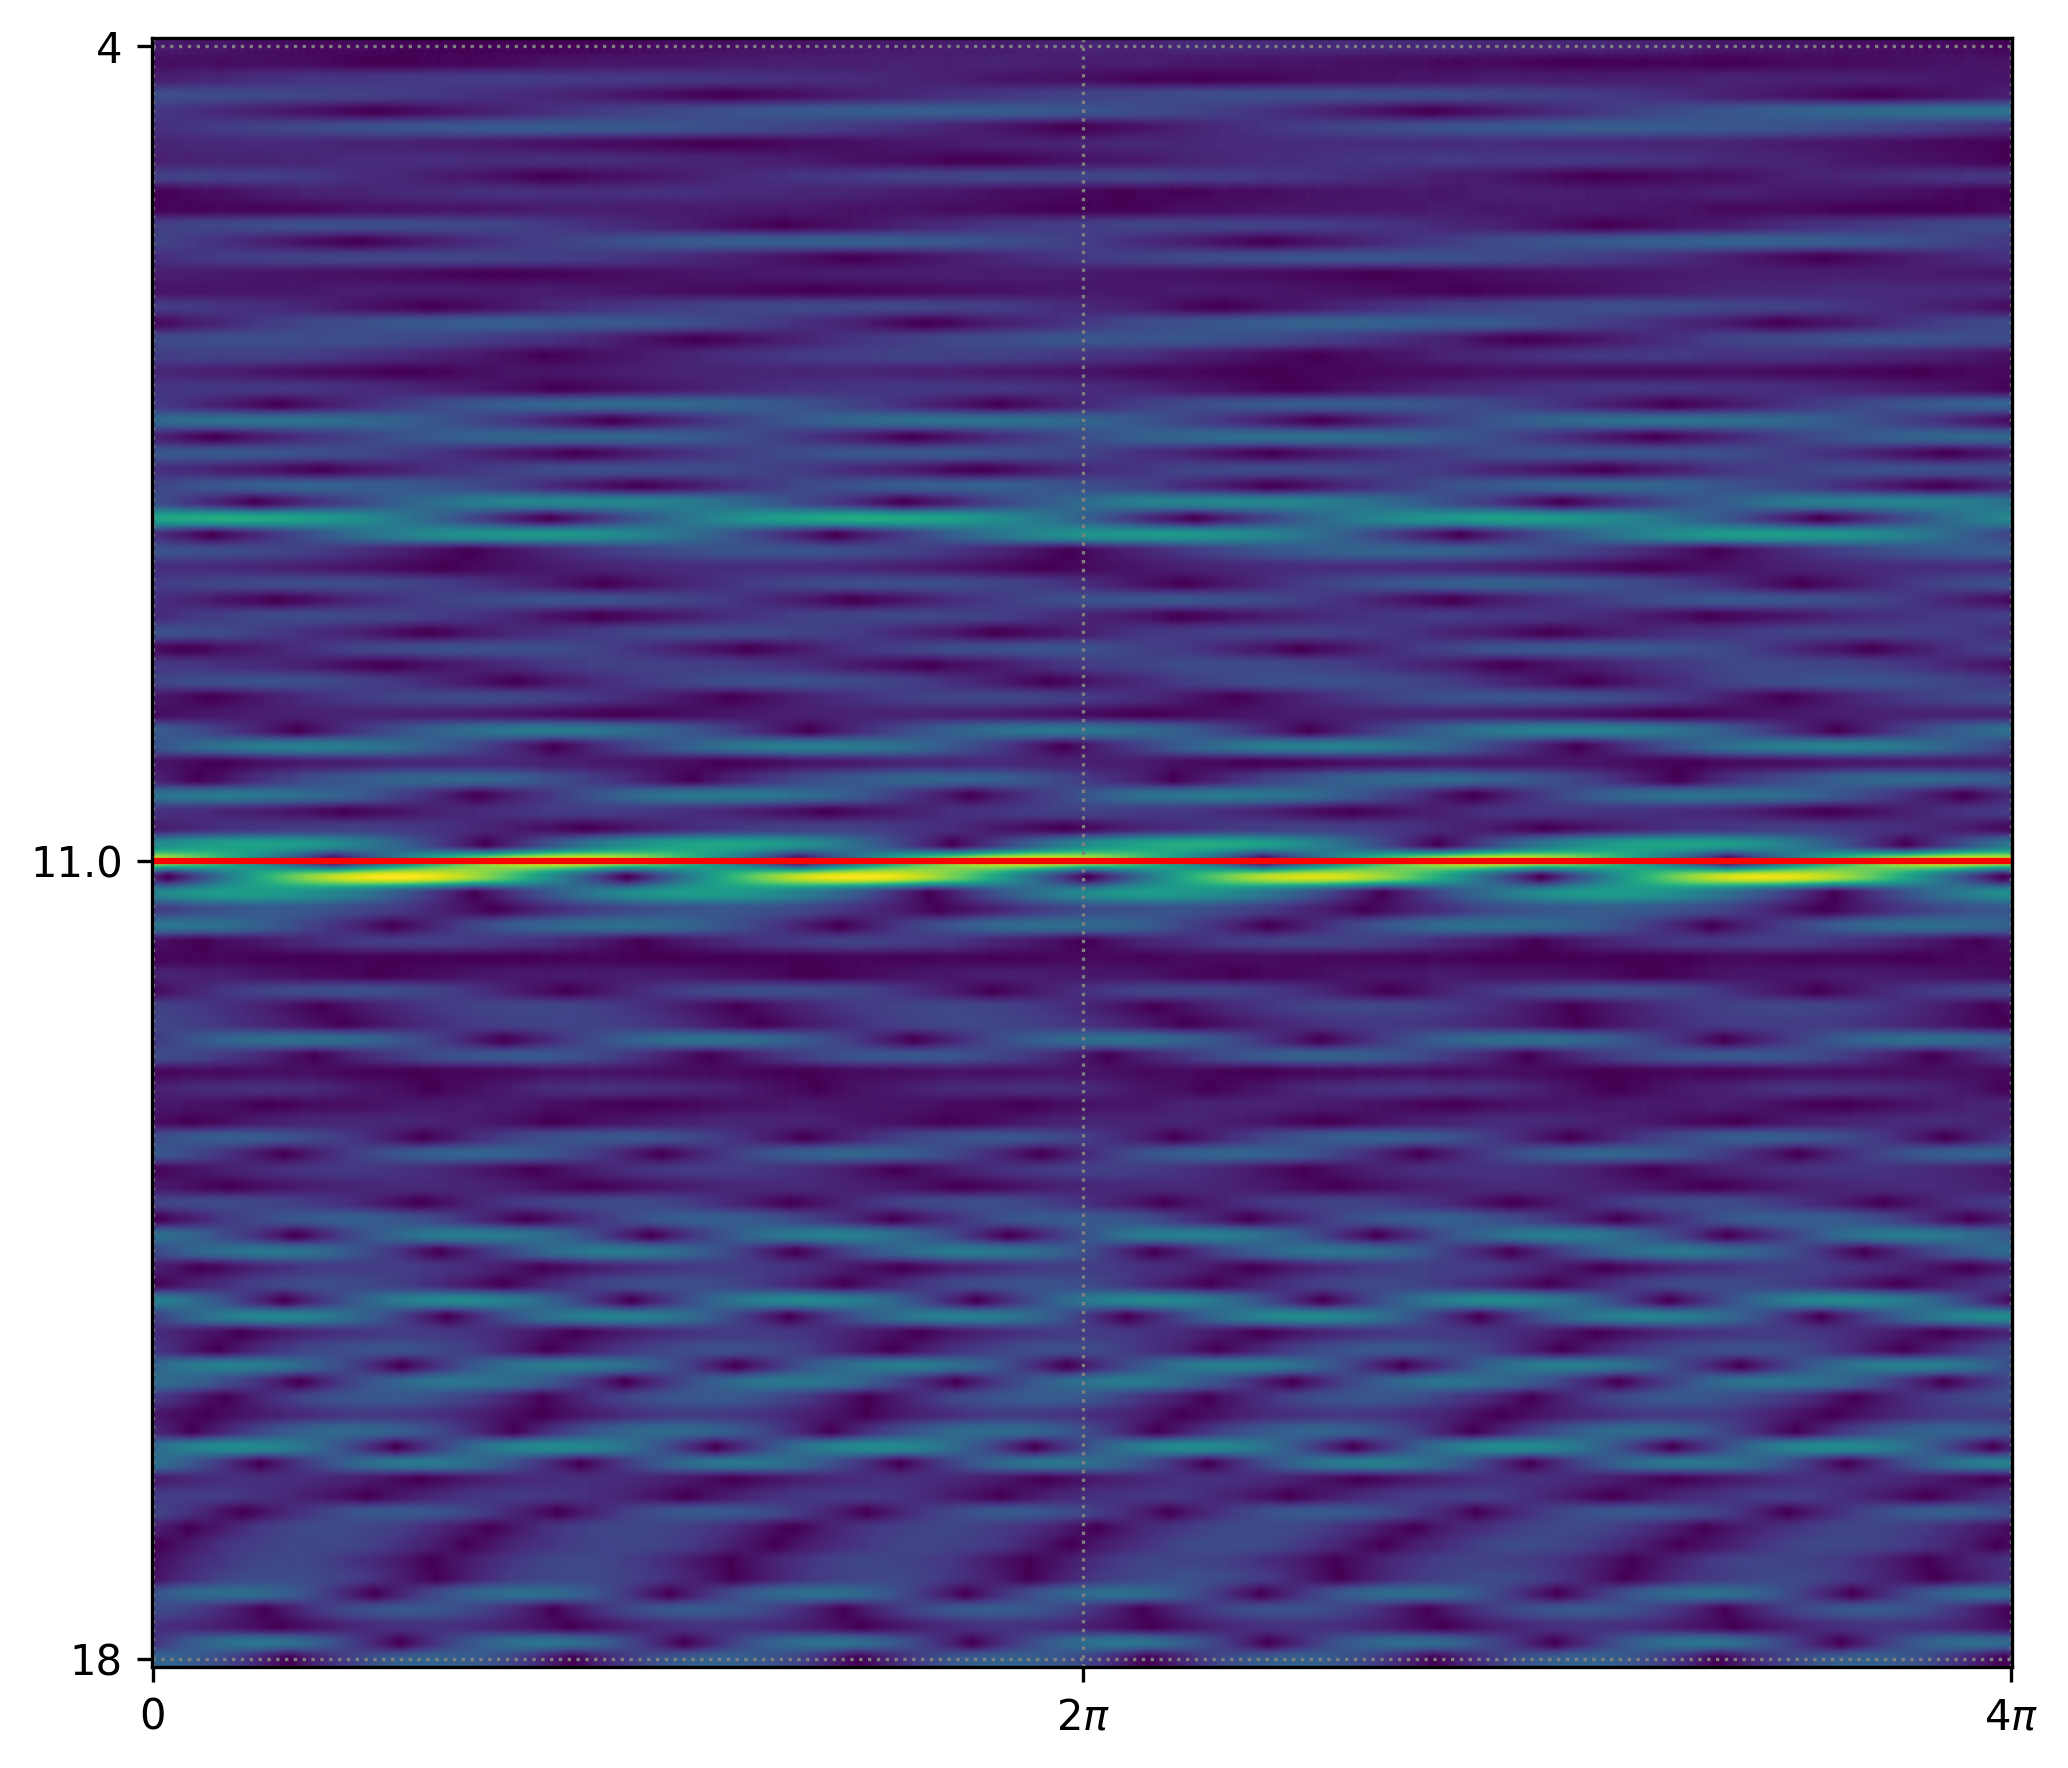

In [11]:
fig = figure(figsize=(8, 12))
plt.imshow(np.abs(CC),aspect=10)
plt.yticks([0,Nw,2*Nw-1],[f'{omega_range[0]:.0f}',str(omega_range[Nw]),f'{omega_range[2*Nw-1]:.0f}'])
plt.xticks([0,int(N0/2),N0-1],[0,'$2\pi$','$4\pi$'])
plt.plot([0,N0-1],[Nw,Nw],'r')
plt.show()

In [12]:
# Look for best correlation across all freq and phi sweeps
ind = np.unravel_index(np.argmax(CC, axis=None), CC.shape)
omega_pred = omega0 + d_omega*(ind[0] - Nw)

In [13]:
f_pred = omega_pred/(2*np.pi) # Hz
T_pred = 1/f_pred  # period in secs
N_pred = int(T_pred/dt) # number of samples per period
phi_pred = ind[1]/N_pred * 2 * np.pi
print(f'True Omega {omega0:.2f} rad/s')
print(f'Pred Omega {omega_pred:.2f} rad/s')
print(f'True Phi {phi_true[0]:.2f} rad')
print(f'Pred Phi {phi_pred:.2f} rad')

True Omega 11.00 rad/s
Pred Omega 11.14 rad/s
True Phi 2.83 rad
Pred Phi 1.66 rad


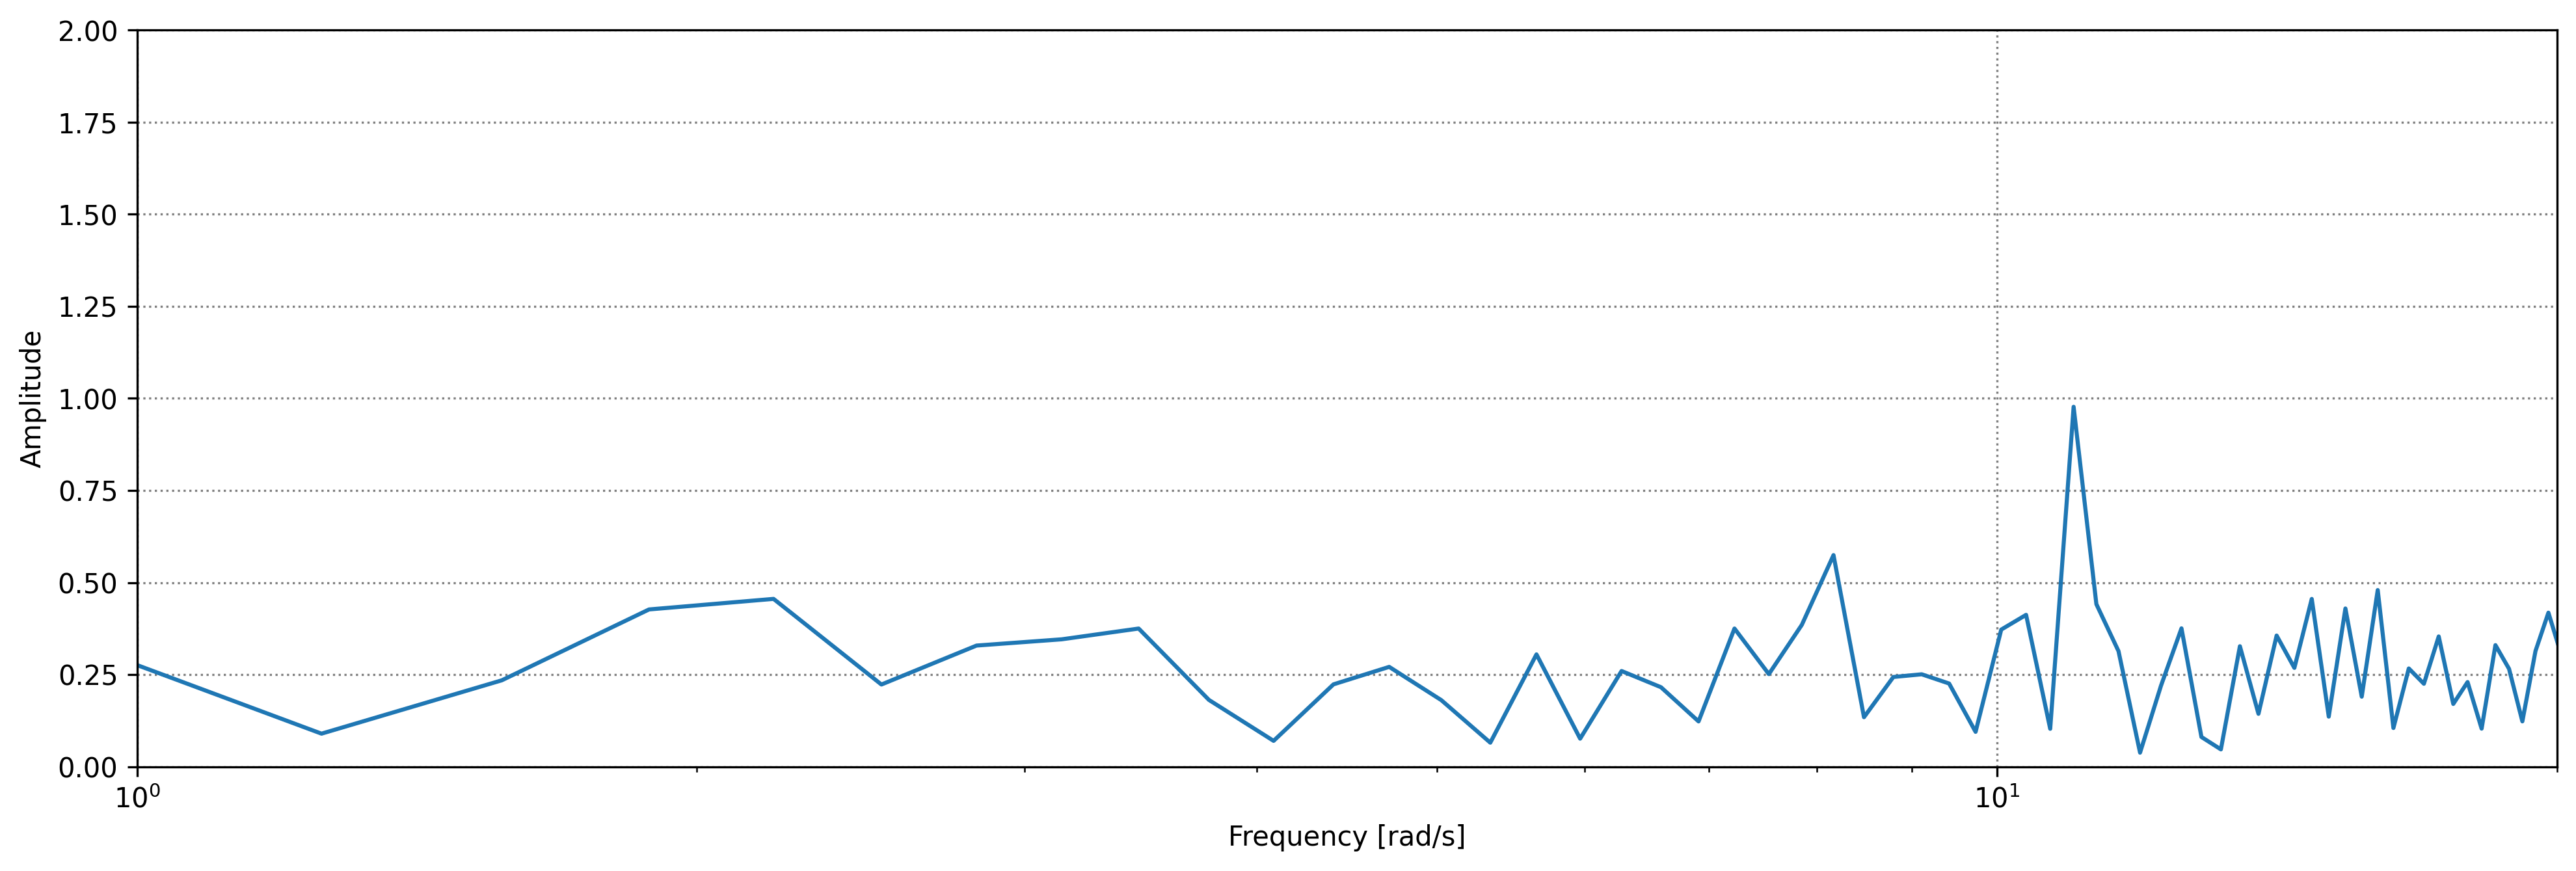

In [14]:
# Alternate way to estimate Omega given the measured data - look for the peak in the FFT plot
from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
Nfft = len(t)

fig = figure(figsize=(16, 5))
yf = fft(y)
ff = fftfreq(Nfft, dt)[1:Nfft//2]*2*np.pi
plt.semilogx(ff, 2.0/Nfft * np.abs(yf[1:Nfft//2]))

plt.ylabel('Amplitude')
plt.xlabel('Frequency [rad/s]')
plt.xlim([1, 20])
plt.ylim([0, 2])
plt.grid(True)
plt.show()